<a href="https://colab.research.google.com/github/Vriksha-Srihari/CD-Project/blob/main/Team13_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset used: 
Disaster Tweets
Real or Not? NLP with Disaster Tweets challenge add-on

Link to dataset: https://www.kaggle.com/vstepanenko/disaster-tweets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download vstepanenko/disaster-tweets

  0% 0.00/656k [00:00<?, ?B/s]
100% 656k/656k [00:00<00:00, 44.5MB/s]


In [ ]:
! mkdir disaster_tweets

In [ ]:
! unzip disaster-tweets.zip -d disaster_tweets

Archive:  disaster-tweets.zip
  inflating: disaster_tweets/tweets.csv  


In [ ]:
import csv
import pandas as pd
import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# **Module 1 - Twitter Dataset**

*   Preprocessing and cleaning tweets (removing numbers, hashtags, links, punctuation) and finally tokenizing them



In [ ]:
#optional execution
with open('disaster_tweets/tweets.csv', 'r') as file:
    reader = csv.reader(file)

In [ ]:
#converting csv file into pandas dataframe
total_data = pd.read_csv('disaster_tweets/tweets.csv')

In [ ]:
#\w stands for "word character", usually [A-Za-z0-9_]
total_data['hashtag'] = total_data['text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [ ]:
display(total_data)

,id,keyword,location,text,target,hashtag
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,[]
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,[]
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,[]
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,[]
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,[]
...,...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0,[]
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0,[]
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0,[]
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0,[]


In [ ]:
#installing ekphrasis
!pip install ekphrasis

     |████████████████████████████████| 80 kB 5.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-py3-none-any.whl size=82842 sha256=05602fe1e77f417409eaa2733275c385641171e2507363478ef3f207c812bd5e
  Stored in directory: /root/.cache/pip/wheels/f7/ec/0d/12659e32faf780546945d0120f2c8410eb3efb7426731da88f
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=776d54fc59da09c168abf227efe43b85407a34f02e3bbdc8ffef0939cd2529cc
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ekphrasis ftfy


In [ ]:
#installing tweet-preprocessor
!pip install tweet-preprocessor

In [ ]:
import preprocessor as p
#forming a separate feature for cleaned tweets
for i,v in enumerate(total_data['text']):
    total_data.loc[i,'cleaned'] = p.clean(v) #code was wrong, corrected now

In [ ]:
display(total_data)

In [ ]:
#important libraries for preprocessing using NLTK
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_data(data):
 #removes numbers
 data = data.astype(str).str.replace('\d+', '')
 # total_data['cleaned'] = data.str.lower()
 # data = data.str.lower()
 lemmatizer = nltk.stem.WordNetLemmatizer()
 w_tokenizer =  TweetTokenizer()
 
 def lemmatize_text(text):
  return [(lemmatizer.lemmatize(w)) for w \
                       in w_tokenizer.tokenize((text))]

 def remove_punctuation(words):
  new_words = []
  for word in words:
    new_word = re.sub(r'[^\w\s]', '', (word))
    if new_word != '':
        new_words.append(new_word)
  return new_words

 words = data.apply(lemmatize_text)
 words = words.apply(remove_punctuation)
 return pd.DataFrame(words)

In [ ]:
pre_tweets = preprocess_data(total_data['cleaned'])
total_data['cleaned'] = pre_tweets #tokenized tweets

In [ ]:
l = [] #list containing tweets with all tokens joined
for lists in total_data['cleaned']:
  l.append(' '.join(lists))

In [ ]:
display(total_data)

,id,keyword,location,text,target,hashtag,cleaned
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,[],"[Communal, violence, in, Bhainsa, Telangana, S..."
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,[],"[Telangana, Section, ha, been, imposed, in, Bh..."
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,[],"[Arsonist, set, car, ablaze, at, dealership]"
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,[],"[Arsonist, set, car, ablaze, at, dealership]"
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,[],"[Lord, Jesus, your, love, brings, freedom, and..."
...,...,...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0,[],"[Media, should, have, warned, u, well, in, adv..."
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0,[],"[i, feel, directly, attacked, i, consider, moo..."
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0,[],"[i, feel, directly, attacked, i, consider, moo..."
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0,[],"[ok, who, remember, outcast, nd, the, dora, au..."


# **Module 2 - Machine Learning Model (Automated Tweets Classifier)**


*   Classifying which tweets are disaster relevant and which aren't
*   Using Bernoulli Naive Bayes Classifier (good for discrete & binary data)



In [ ]:
#converts a collection of text documents to a matrix of token counts
#used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text 
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x = cv.fit_transform(l).toarray()

In [ ]:
display(x)
display(type(x))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

numpy.ndarray

In [ ]:
#splitting current dataset into a train and test dataset (80%-20%)
from sklearn.model_selection import train_test_split
train_text , test_text , train_target , test_target = train_test_split(x, total_data['target'], test_size=0.2, random_state=2020)

In [ ]:
print(type(train_text))

<class 'numpy.ndarray'>


In [ ]:
from sklearn import svm
model = svm.SVC(kernel='linear')

hist = model.fit(train_text, train_target)

In [ ]:
from sklearn import metrics
#get predictions
model_pred = model.predict(test_text)

#calculate the accuracy 
model_score = metrics.accuracy_score(test_target, model_pred)

print('SVM Model Score: ', model_score)

SVM Model Score:  0.886103781882146


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


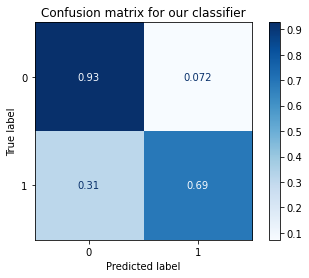

In [ ]:
#generate confusion matrix
from sklearn.metrics import plot_confusion_matrix

matrix = plot_confusion_matrix(hist, test_text, test_target, cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

# **Module 3 - Retrieval of Relevant Tweets**


*   Creating a list of relevant tweets based on the predictions made by the machine learning model 
*   Relevant tweets are those with target value = 1




In [ ]:
train_text1 , test_text1 , train_target1 , test_target1 = train_test_split(total_data, total_data['target'], test_size=0.2, random_state=2020) #split without CountVectorizing

In [ ]:
 print(test_text1.columns.values.tolist())
 test_text_ncv = test_text1.values.tolist()
 print(type(test_text_ncv))
 print(test_text_ncv[0])

['id', 'keyword', 'location', 'text', 'target', 'hashtag', 'cleaned']
<class 'list'>
[2971, 'damage', 'Bangkok, Thailand', 'Nope! First he spoke what he thin… https://t.co/mPirnwMu2l', 0, [], ['Nope', 'First', 'he', 'spoke', 'what', 'he', 'thin']]


In [ ]:
#display number of relevant predictions
count = 0
for i in model_pred :
  if i == 1 :
    count += 1
print(count)

408


In [ ]:
#retrieve corresponding relevant tweets
index = 0
count = 0
rel_tweets = []
for i in model_pred :
  index += 1
  if i == 1 :
    rel_tweets.append(test_text_ncv[index][6])
    if test_text_ncv[index][4] == i:
      count = count + 1

In [ ]:
for tweet in rel_tweets :
  tweet = ' '.join(tweet)

# **Module 4 - Location Based Tweets - GeoTag**


*   Parsing tweet text for locations (cities and countries)





In [ ]:
! pip install geotext

In [ ]:
from geotext import GeoText

In [ ]:
list_of_places = [] 
for tweet in rel_tweets :
  list_of_places.append(GeoText(' '.join(tweet)))

# **Module 5 - Automatic Emergency Alerting Interface**


*   Creating a dataframe with the affected places and their corresponding tweets
*   Displaying a histogram depicting the areas most prone to disasters

In [ ]:
places = []
total = []
corresponding_tweets = []
i = 0
for place in list_of_places:
  if (len(place.countries) > 0):
    places.append(place.countries)
    corresponding_tweets.append(' '.join(rel_tweets[i]))
    for p in place.countries:
      total.append(p)

  if (len(place.cities) > 0):
    places.append(place.cities)
    corresponding_tweets.append(' '.join(rel_tweets[i]))
    for p in place.cities:
      total.append(p)
  
  i = i + 1

In [ ]:
print(places)
print(corresponding_tweets)

[['Taal'], ['Puerto Rico'], ['Australia'], ['Ho'], ['Brent'], ['Lucknow'], ['Union'], ['Most'], ['Washington'], ['Venice'], ['Australia'], ['Japan'], ['Talisay'], ['Australia'], ['Kenya', 'India', 'Israel'], ['Of'], ['Olympia'], ['Clinton'], ['Denmark'], ['Israel'], ['Vienna'], ['India'], ['Man'], ['Philippines'], ['Batangas'], ['Phoenix'], ['La Grange'], ['India'], ['Surfers Paradise'], ['Police', 'Kota'], ['Goldsboro'], ['Abuja'], ['Fier'], ['Jersey City'], ['Auburn'], ['China', 'Thailand'], ['Zhuhai'], ['Libya'], ['France'], ['Dover'], ['Warren'], ['Hitchin'], ['Taal'], ['Police'], ['Thailand', 'China'], ['Chile'], ['Iran'], ['Taiwan'], ['Iran'], ['Man'], ['Paris'], ['Israel'], ['Obama'], ['India', 'India']]
['Philippine authority are warning that a large dangerous eruption from the Taal volcano may be imminent after a t', 'Puerto Rico hit by another magnitude aftershock KYMA', 'Here we are in Australia in the middle of summer Trapped in our homesthe air outside filled with smoke fr

In [ ]:
df = pd.DataFrame(list(zip(places, corresponding_tweets)),
               columns =['Countries/Cities', 'Corresponding Tweets'])

In [ ]:
display(df)

,Countries/Cities,Corresponding Tweets
0,[Taal],Philippine authority are warning that a large ...
1,[Puerto Rico],Puerto Rico hit by another magnitude aftershoc...
2,[Australia],Here we are in Australia in the middle of summ...
3,[Ho],Geez Mike They couldnt get their Landcruisers ...
4,[Brent],I think it an aftershock from s lyrical beat d...
5,[Lucknow],Anti CAA ProtestrofRobin Verma released from L...
6,[Union],MEG issue Areal Flood Advisory for Alcorn Bent...
7,[Most],On Scorched Earth People Most of them have the...
8,[Washington],Washington ha an avalanche rescue goat His nam...
9,[Venice],Venice canal almost dry two month after severe...


In [ ]:
countries = []
for places in list_of_places :
  for country in places.countries :
    countries.append(country)

cities = []
for places in list_of_places :
  for city in places.cities :
    cities.append(city)

In [ ]:
print("COUNTRIES WITH DISASTERS:")
for country in countries :
    print(country)
print("\nCITIES WITH DISASTERS:")
for city in cities :
    print(city)

COUNTRIES WITH DISASTERS:
Puerto Rico
Australia
Australia
Japan
Australia
Kenya
India
Israel
Denmark
Israel
India
Philippines
India
China
Thailand
Libya
France
Thailand
China
Chile
Iran
Taiwan
Iran
Israel
India
India

CITIES WITH DISASTERS:
Taal
Ho
Brent
Lucknow
Union
Most
Washington
Venice
Talisay
Of
Olympia
Clinton
Vienna
Man
Batangas
Phoenix
La Grange
Surfers Paradise
Police
Kota
Goldsboro
Abuja
Fier
Jersey City
Auburn
Zhuhai
Dover
Warren
Hitchin
Taal
Police
Man
Paris
Obama


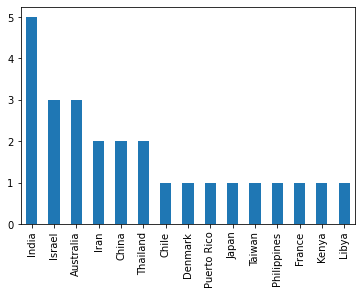

In [ ]:
df = pd.DataFrame(list(zip(countries, cities)),
               columns =['Countries', 'Cities'])
fig, ax = plt.subplots()
df['Countries'].value_counts().plot(ax=ax, kind='bar')
plt.show() #country-wise

In [ ]:
df1 = pd.DataFrame(list(zip(total)),
               columns =['Countries/Cities'])

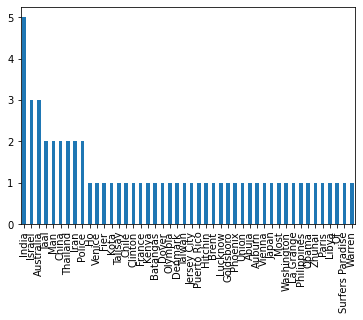

In [ ]:
fig, ax = plt.subplots()
df1['Countries/Cities'].value_counts().plot(ax=ax, kind='bar')
plt.show() #countries and cities together